In [1]:
from utilities import *

In [340]:
cur_node

((-1, -1), (-1, -1), [])

In [4]:
dataset = database_covers('map_data/Lemko/')
points = parse_gpx_to_points('gpx_data/lemko.gpx')

In [5]:
(result, elevation_map) = get_elevation_for_points(dataset, points)

In [7]:
elevation_gpx = [ele for _, ele in points2]

In [22]:
# try to fill missing values with average of positive values to the left and right
for i in range(len(elevation_map)):
    if elevation_map[i] < 0:
        left_i = i - 1
        while left_i >= 0 and elevation_map[left_i] < 0:
            left_i -= 1
        right_i = i + 1
        while right_i < len(elevation_map) and elevation_map[right_i] < 0:
            right_i += 1
        elevation_map[i] = (elevation_map[left_i] + elevation_map[right_i]) / 2


In [201]:
from scipy.interpolate import lagrange, interp1d
from scipy.misc import derivative

def interpolate_elevation(elevation_map, n, last_x = None):
    # get random 1000 points
    x = np.random.randint(0, len(elevation_map), n)
    np.append(x, [0, 1, 2, len(elevation_map) - 3, len(elevation_map) - 2, len(elevation_map) - 1])
    x = list(sorted(set(x)))
    y = np.array([elevation_map[i] for i in x])
    if last_x is not None:
        x = [last_x[i] for i in x]

    f = interp1d(x, y, kind='cubic', fill_value='extrapolate')
    xnew = np.arange(0, len(elevation_map) - 1)
    if last_x is not None:
        xnew = np.array(last_x)
    ynew = f(xnew)

    df = derivative(f, xnew, dx=1)

    return f, df, ynew

f, df, interpolated = interpolate_elevation(elevation_map, 500)
f2, df, interpolated2 = interpolate_elevation(interpolated, 100)

/tmp/ipykernel_16801/1291700007.py:19: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  df = derivative(f, xnew, dx=1)


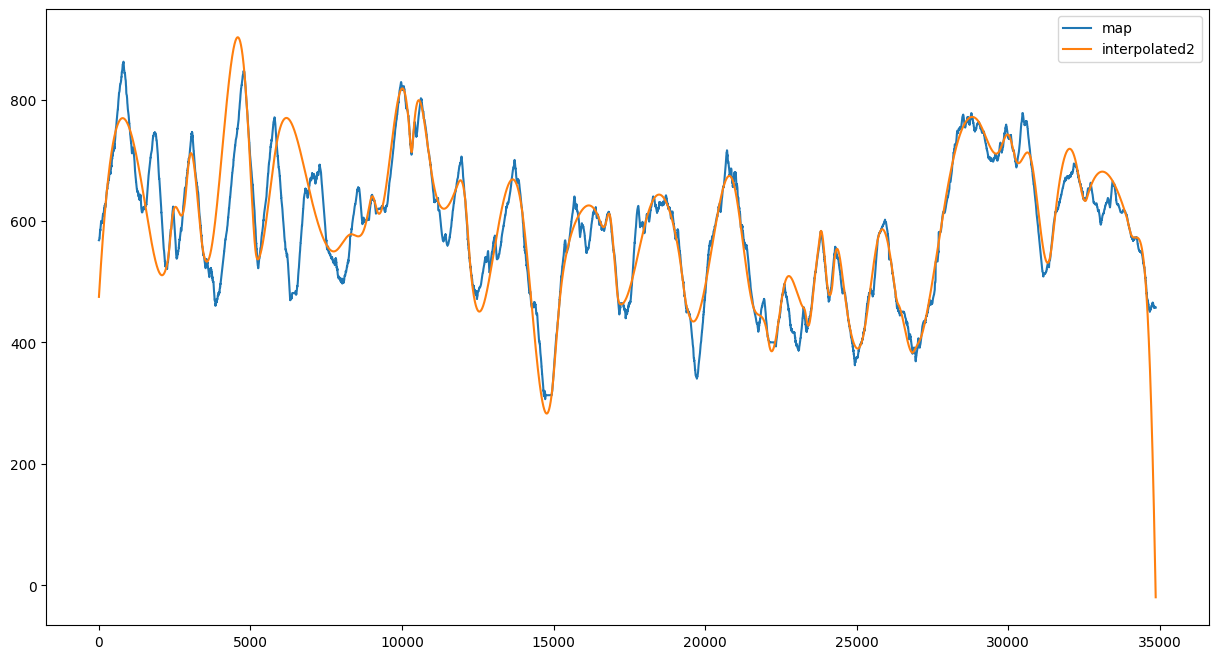

In [170]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 8))
plt.plot(elevation_map, label='map')
plt.plot(interpolated2, label='interpolated2')
plt.legend()
plt.show()

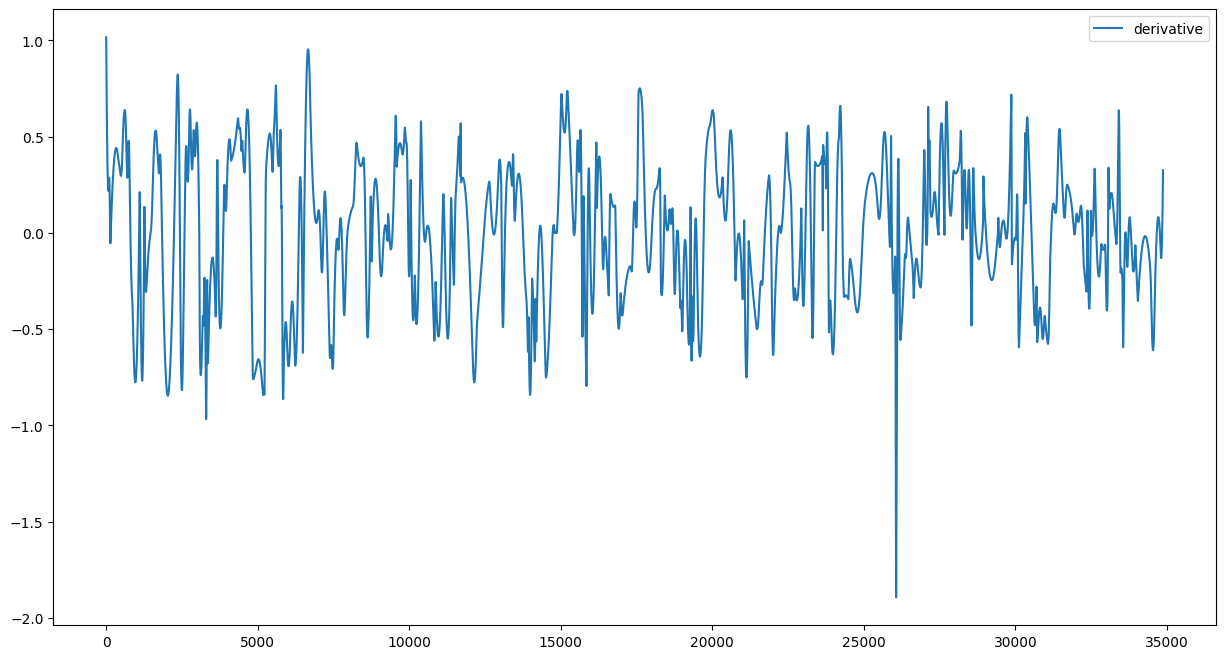

In [84]:
plt.figure(figsize=(15, 8))
plt.plot(df, label='derivative')
plt.legend()
plt.show()

In [85]:
_, _, interpolated2 = interpolate_elevation(df)

/tmp/ipykernel_16801/2953475812.py:15: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  df = derivative(f, xnew, dx=1)


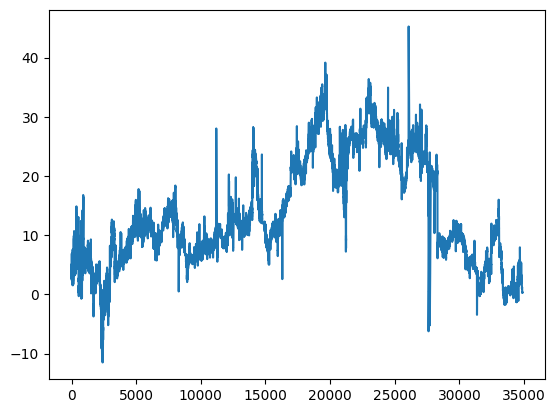

In [17]:
# calculate difference
diff = elevation_gpx - elevation_map
plt.plot(diff)
plt.show()

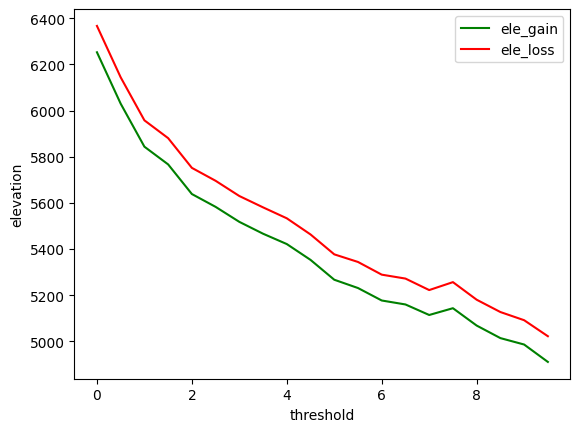

+-----------+----------+----------+
| threshold | ele_gain | ele_loss |
+-----------+----------+----------+
|    0.0    |  6252.8  |  6367.0  |
|    0.5    |  6030.0  |  6144.2  |
|    1.0    |  5843.6  |  5957.8  |
|    1.5    |  5766.8  |  5880.6  |
|    2.0    |  5638.4  |  5751.8  |
|    2.5    |  5582.8  |  5695.8  |
|    3.0    |  5517.8  |  5629.8  |
|    3.5    |  5466.4  |  5580.6  |
|    4.0    |  5421.6  |  5533.2  |
|    4.5    |  5353.0  |  5463.2  |
|    5.0    |  5267.0  |  5377.0  |
|    5.5    |  5231.0  |  5344.0  |
|    6.0    |  5177.0  |  5289.0  |
|    6.5    |  5159.8  |  5272.0  |
|    7.0    |  5114.2  |  5222.2  |
|    7.5    |  5143.6  |  5256.6  |
|    8.0    |  5068.4  |  5180.4  |
|    8.5    |  5014.0  |  5127.0  |
|    9.0    |  4986.2  |  5091.6  |
|    9.5    |  4910.8  |  5022.2  |
+-----------+----------+----------+


In [98]:
MAX_THRESHOLD = 10
STEP = 0.5

def plot_diff():
    ele_gain, ele_loss = [], []
    for i in np.arange(0, MAX_THRESHOLD, STEP):
        last_ele = elevation_gpx[0]
        temp = 0
        gain, loss = 0, 0
        for ele in elevation_gpx[1:]:
            temp += ele - last_ele
            if temp > i:
                gain += temp
                temp = 0
            elif temp < -i:
                loss += temp
                temp = 0
            last_ele = ele
        ele_gain.append(gain)
        ele_loss.append(-loss)

    plt.xlabel('threshold')
    plt.ylabel('elevation')
    plt.plot(np.arange(0, MAX_THRESHOLD, STEP), ele_gain, label='ele_gain', color='green')
    plt.plot(np.arange(0, MAX_THRESHOLD, STEP), ele_loss, label='ele_loss', color='red')
    plt.legend()
    plt.show()

    import prettytable

    table = prettytable.PrettyTable()
    table.field_names = ['threshold', 'ele_gain', 'ele_loss']
    for i in range(len(ele_gain)):
        table.add_row([i * STEP, round(ele_gain[i], 2), round(ele_loss[i], 2)])
    print(table)


plot_diff()

In [301]:
def cut_to_threshold(data, threshold):
    x = [0]
    y_res = [data[0]]
    temp = 0
    for i in range(1, len(data)):
        temp += data[i] - data[i - 1]
        if temp > threshold or temp < -threshold:
            x.append(i)
            y_res.append(data[i])
            temp = 0

    x.append(len(data) - 1)
    y_res.append(data[-1])

    return x, y_res

x_res, y_res = cut_to_threshold(elevation_map, 1.5)

In [221]:
_, df, interpolated = interpolate_elevation(y_res, 200, x_res)

/tmp/ipykernel_16801/1291700007.py:19: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  df = derivative(f, xnew, dx=1)


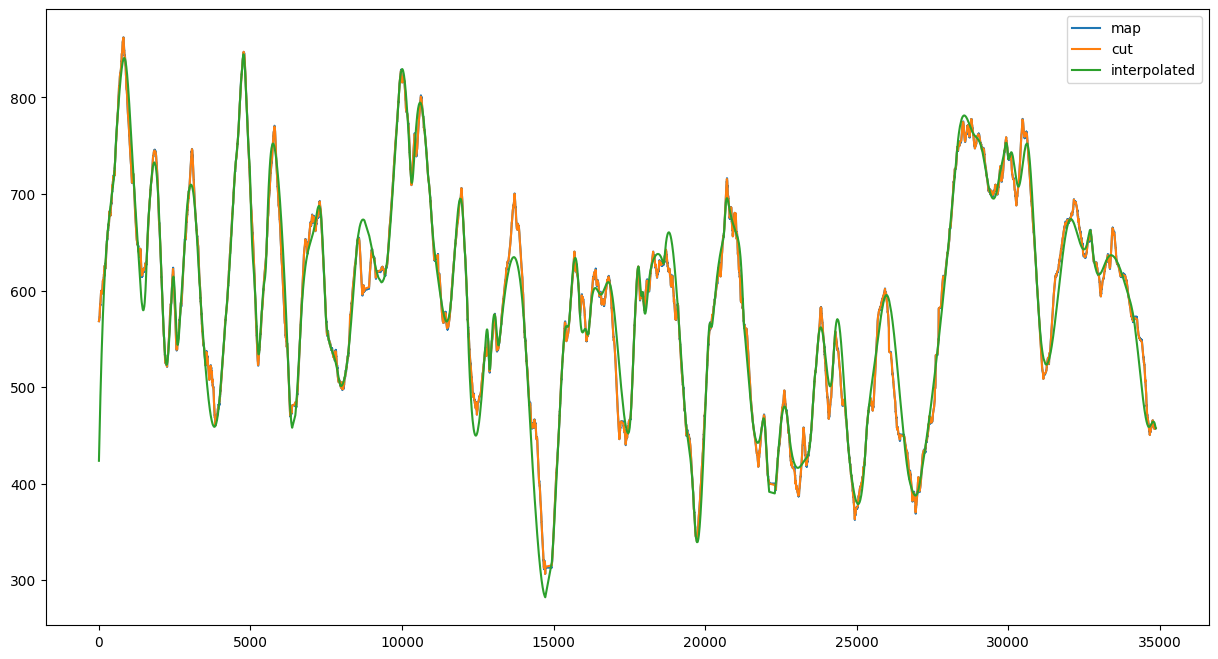

In [222]:
plt.figure(figsize=(15, 8))

plt.plot(elevation_map, label='map')
plt.plot(x_res, y_res, label='cut')
plt.plot(x_res, interpolated, label='interpolated')
plt.legend()
plt.show()

In [288]:
def find_climbs_descends(diffs):
    climbs, descends = [], []
    last_ele = diffs[0]
    temp = 0
    if last_ele > 0:
        climbs.append(temp)
    else:
        descends.append(temp)
    for i in range(1, len(diffs)):
        if last_ele * diffs[i] < 0:
            if last_ele > 0:
                descends.append(i + 13)
            else:
                climbs.append(i + 13)
            last_ele = diffs[i]
    return climbs, descends

np_y = np.array(y_res)
diff = np_y[1:] - np_y[:-1]

sum25 = [sum(diff[i:i+25]) for i in range(len(diff) - 25)]
sum25 = np.array(sum25)

climbs, descends = find_climbs_descends(sum25)

In [277]:
climb_descend_sca_x = [x_res[i] for i in climbs] + [x_res[i] for i in descends]
climb_descend_sca_y = [1 for _ in climbs] + [-1 for _ in descends]

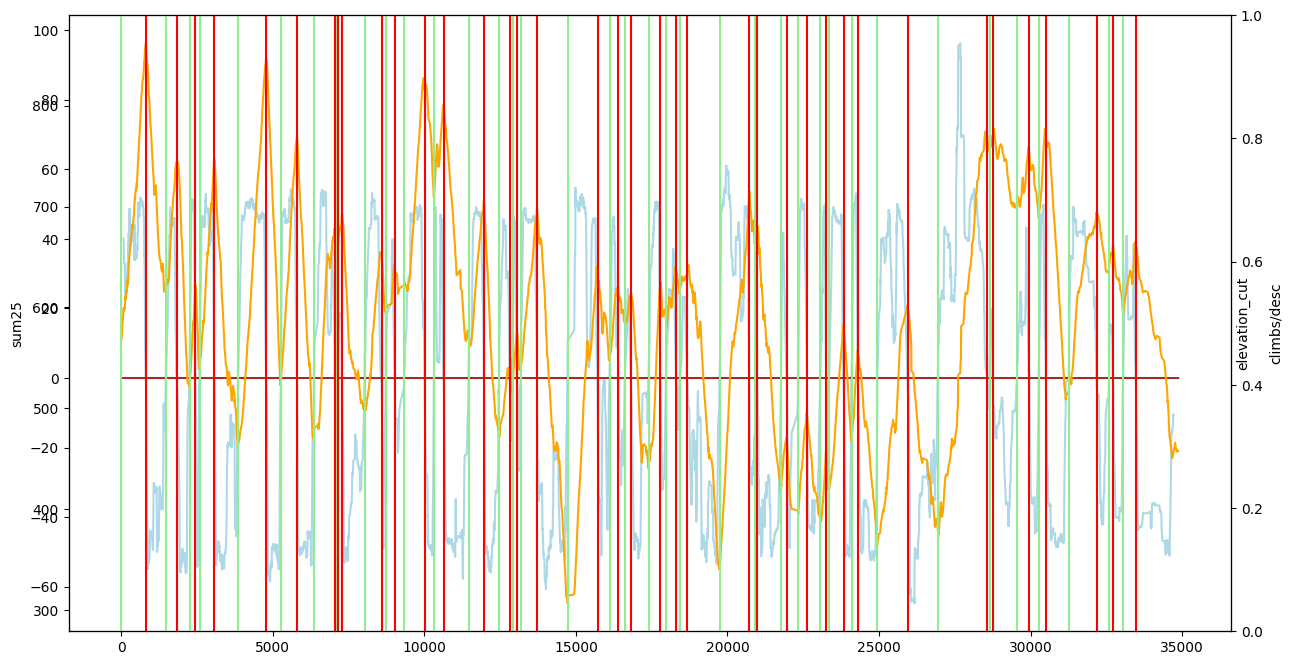

In [283]:
np_y = np.array(y_res)
diff = np_y[1:] - np_y[:-1]

sum25 = [sum(diff[i:i+25]) for i in range(len(diff) - 25)]
sum25 = np.array(sum25)

fig, ax1 = plt.subplots()
fig.set_size_inches(15, 8)

ax1.set_ylabel('sum25')
ax1.plot(x_res[13:-13], sum25, color='lightblue')

ax2 = ax1.twinx()
ax2.set_ylabel('elevation_cut')
ax2.plot(x_res, y_res, color='orange')

ax3 = ax2.twinx()
ax3.set_ylabel('climbs/desc')
for i in range(len(climbs)):
    ax3.axvline(x=x_res[climbs[i]], color='lightgreen')

for i in range(len(descends)):
    ax3.axvline(x=x_res[descends[i]], color='red')

ax1.plot(x_res, [0 for _ in range(len(x_res))], color='brown')

plt.show()

ValueError: x and y must have same first dimension, but have shapes (806,) and (2,)

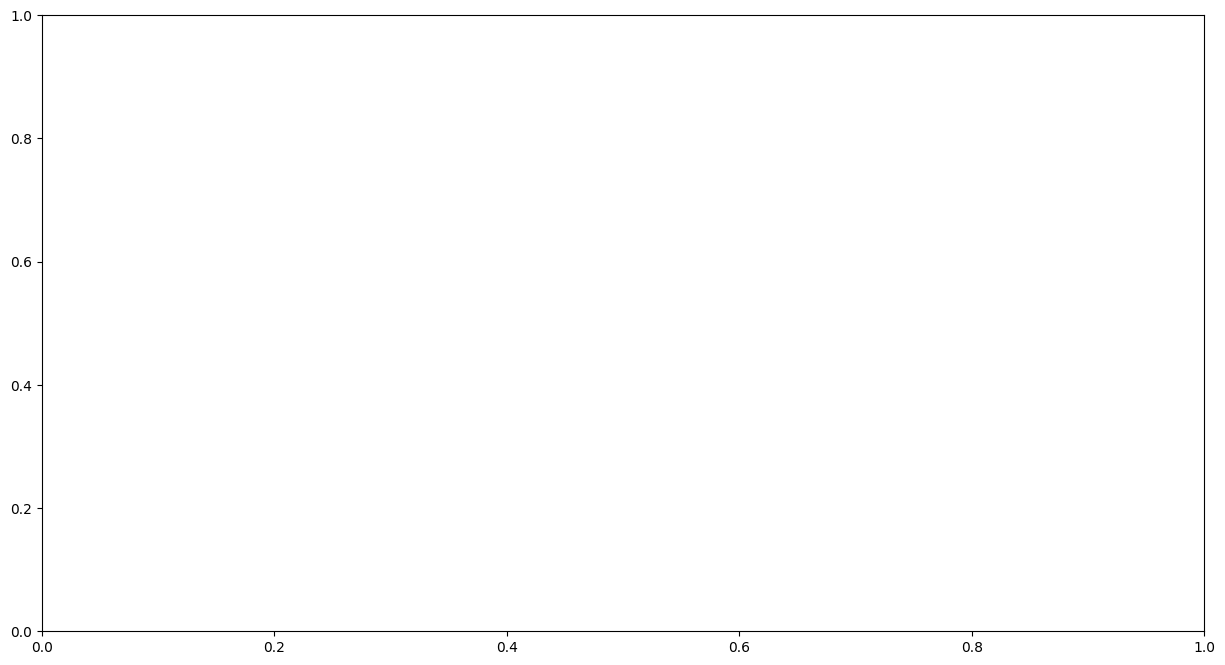

In [344]:
data_cutx = np.array(x_res)
data_cuty = np.array(y_res)

# Ascending is first
begin_climb = [data_cutx[i] for i in climbs]
begin_descend = [data_cutx[i] for i in descends]
end_climb = [begin_descend[i] - 1 for i in range(len(begin_descend))]
end_descend = [begin_climb[i] - 1 for i in range(len(begin_climb))][1:] + [data_cutx[-1]]

def distance(point1, point2):
    from haversine import haversine
    point1 = (point1[1], point1[0])
    point2 = (point2[1], point2[0])
    return haversine(point1, point2)

def points_to_cumulativedistance(points):
    cumulativedistance = [0]
    for i in range(1, len(points)):
        cumulativedistance.append(cumulativedistance[-1] + distance(points[i - 1][0], points[i][0]))
    return cumulativedistance

cumsum = [int(x * 1000) for x in points_to_cumulativedistance(points_run)]

plt.figure(figsize=(15, 8))
plt.xlabel('Distance (m)')
plt.xticks(range(0, cumsum[-1], 1000))
for i in range(0, cumsum[-1], 1000):
    plt.axvline(i, color='gray', linestyle='--', linewidth=0.5)
plt.plot(cumsum, elevation_map_run)
for i in range(len(begin_climb)):
    plt.plot([cumsum[x] for x in range(begin_climb[i], end_climb[i])], elevation_map_run[begin_climb[i]:end_climb[i]], color='green')

for i in range(len(begin_descend)):
    plt.plot([cumsum[x] for x in range(begin_descend[i], end_descend[i])], elevation_map_run[begin_descend[i]:end_descend[i]], color='red')

plt.show()

In [345]:
l = zip(begin_climb, end_climb)
print(list(zip(begin_climb, end_climb)))
print(list(zip(begin_descend, end_descend)))
print(len(begin_climb))


[(0, 806), (1473, 1831), (2252, 2442), (2580, 3069), (3847, 4780), (5266, 5802), (6365, 7052), (7089, 7133), (7138, 7283), (8023, 8584), (8729, 9017), (9327, 10005), (10316, 10639), (11455, 11969), (12468, 12815), (12909, 13058), (13190, 13714), (14723, 15713), (16110, 16399), (16620, 16816), (17402, 17785), (17968, 18298), (18424, 18665), (19754, 20719), (20923, 20984), (21768, 21961), (22342, 22621), (23068, 23263), (23365, 23837), (24100, 24309), (24947, 25941), (26948, 28570), (28648, 28751), (29559, 29962), (30273, 30502), (31267, 32182), (32593, 32718), (33062, 33473)]
[(807, 1472), (1832, 2251), (2443, 2579), (3070, 3846), (4781, 5265), (5803, 6364), (7053, 7088), (7134, 7137), (7284, 8022), (8585, 8728), (9018, 9326), (10006, 10315), (10640, 11454), (11970, 12467), (12816, 12908), (13059, 13189), (13715, 14722), (15714, 16109), (16400, 16619), (16817, 17401), (17786, 17967), (18299, 18423), (18666, 19753), (20720, 20922), (20985, 21767), (21962, 22341), (22622, 23067), (23264, 

In [347]:
print(data_cutx)
print(elevation_map)

[    0    13    23 ... 34832 34835 34873]
(52.244648, 21.184393)
